In [5]:
import sys
import time
import numpy as np
import pandas as pd
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler
#from pandas.core.common import array_equivalent
import pickle
#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn import metrics
from xgboost import plot_importance
from matplotlib import pyplot
import matplotlib.pylab as plt
#get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 7, 3
from datetime import datetime
print('Start Time: ', str(datetime.now()))

Start Time:  2020-07-22 13:40:19.028108


In [6]:
#Data read by chunk
import csv
import gc
def get_data(directory, file_list, chunksize, data_type_list = None, use_col_list = None):
    data = None
    for i, file_name in enumerate(file_list):
        #print (file_name)
        subset = None
        for j, chunk in enumerate(
                pd.read_csv(directory + file_name, chunksize=chunksize, low_memory=False, index_col=0)):
            #print (j)
            if subset is None:
                subset = chunk.copy()
            else:
                subset = pd.concat([subset, chunk])
            del chunk
            gc.collect()
        if data is None:
            data = subset.copy()
        else:
            data = pd.merge(data, subset.copy(), on="Id")
        del subset
        gc.collect()

    return data

# Train  dataframe
train = get_data('D:/Project/Sample data/', ['train_data_sample1.csv'], 10000)
columns = train.drop(["Response"], axis=1).columns

In [7]:
len(train)

8000

In [8]:
train.shape

(8000, 1157)

In [9]:
# Function 
def modelfit(alg, X_all, y_all,i, useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    import xgboost as xgb


    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_all, label=y_all)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=1)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_all, y_all, eval_metric=['auc'])
    
    print(alg)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_all)
    dtrain_predprob = alg.predict_proba(X_all)[:,1]
    
    sorted_idx = np.argsort(alg.feature_importances_)[::-1]
    f_name = []
    score = []
    print('Important Features:')
    for index in sorted_idx:
        f_name.append(columns[index])
        score.append(alg.feature_importances_[index])
    im_Feature= pd.DataFrame(f_name, columns =["f_name"])
    im_Feature["score"] = score
    im_Feature=im_Feature.head(49)
    out_file = "D:/input output csv_chunk" + "/data_{}.csv".format(i+1)

    im_Feature.to_csv(out_file)
    print(im_Feature.head())
    #Print model report:
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_all, dtrain_predprob))

    out_file = "D:/input output csv_chunk" + "/data_{}.png".format(i+1)

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)[:25]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.savefig(out_file)
    print(feat_imp.to_string())
    del alg
    gc.collect()
    


df size : 8000
2666.6666666666665
rc: 2666
size: 8000
Id
428       0
625       0
1046      0
1228      0
1311      0
1660      0
1716      0
1744      0
2110      0
2543      0
3702      0
3808      0
4177      0
5011      0
5256      0
5573      0
5611      0
5693      0
6103      0
6231      0
7839      0
8296      0
8422      0
8995      0
9263      0
9524      0
10078     0
10170     0
11089     0
11108     0
         ..
780903    0
781054    0
781092    0
781372    0
781586    0
781631    0
781670    0
781736    0
781880    0
782685    0
782711    0
782813    0
783467    0
784216    0
784494    1
784525    0
785328    0
786011    0
786477    0
787229    0
787631    0
787680    0
787924    0
788029    0
788039    0
788272    0
788287    0
788589    0
789218    0
789252    0
Name: Response, Length: 2666, dtype: int64
[0]	train-auc:0.835538+0.0427119	test-auc:0.599319+0.0974926


C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[1]	train-auc:0.859844+0.0515951	test-auc:0.595879+0.100618
[2]	train-auc:0.903127+0.0127746	test-auc:0.621998+0.129634
[3]	train-auc:0.920458+0.00448427	test-auc:0.61219+0.123014
[4]	train-auc:0.929074+0.0189758	test-auc:0.663069+0.144683
[5]	train-auc:0.946314+0.0155197	test-auc:0.701111+0.133789
[6]	train-auc:0.960102+0.00825294	test-auc:0.707257+0.136444
[7]	train-auc:0.965945+0.00398409	test-auc:0.704912+0.137011
[8]	train-auc:0.975791+0.00547289	test-auc:0.695822+0.139319
[9]	train-auc:0.974097+0.00452605	test-auc:0.699586+0.14104
[10]	train-auc:0.979432+0.00496295	test-auc:0.711916+0.12335
[11]	train-auc:0.983009+0.00736164	test-auc:0.735047+0.0872924
[12]	train-auc:0.984064+0.00938568	test-auc:0.734964+0.0901965
[13]	train-auc:0.985837+0.00832082	test-auc:0.73503+0.0905204
[14]	train-auc:0.987259+0.00752416	test-auc:0.731824+0.107261
[15]	train-auc:0.987405+0.00776016	test-auc:0.730367+0.100026
[16]	train-auc:0.987856+0.00690462	test-auc:0.726304+0.105239
[17]	train-auc:0.98825

C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-auc:0.793697+0.0335954	test-auc:0.641447+0.0731511
[1]	train-auc:0.852067+0.017164	test-auc:0.663288+0.0742781
[2]	train-auc:0.877696+0.0218043	test-auc:0.670328+0.0660945
[3]	train-auc:0.894726+0.0142886	test-auc:0.63339+0.0870121
[4]	train-auc:0.904185+0.0121682	test-auc:0.661625+0.0930334
[5]	train-auc:0.915695+0.0130018	test-auc:0.671989+0.073404
[6]	train-auc:0.929686+0.0113154	test-auc:0.696302+0.0491023
[7]	train-auc:0.933382+0.0131947	test-auc:0.696359+0.0506101
[8]	train-auc:0.937342+0.0123485	test-auc:0.704505+0.0475785
[9]	train-auc:0.941013+0.0120405	test-auc:0.707988+0.0616935
[10]	train-auc:0.942464+0.0129567	test-auc:0.711083+0.0624887
[11]	train-auc:0.945057+0.011185	test-auc:0.710549+0.0624175
[12]	train-auc:0.94837+0.0102863	test-auc:0.704968+0.0689644
[13]	train-auc:0.953048+0.0121173	test-auc:0.704061+0.0662504
[14]	train-auc:0.955452+0.0104064	test-auc:0.702027+0.0707377
[15]	train-auc:0.956249+0.0102747	test-auc:0.697832+0.0690676
[16]	train-auc:0.957697

C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Rezaul Abedin\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-auc:0.793697+0.0335954	test-auc:0.641447+0.0731511
[1]	train-auc:0.852067+0.017164	test-auc:0.663288+0.0742781
[2]	train-auc:0.877696+0.0218043	test-auc:0.670328+0.0660945
[3]	train-auc:0.894726+0.0142886	test-auc:0.63339+0.0870121
[4]	train-auc:0.904185+0.0121682	test-auc:0.661625+0.0930334
[5]	train-auc:0.915695+0.0130018	test-auc:0.671989+0.073404
[6]	train-auc:0.929686+0.0113154	test-auc:0.696302+0.0491023
[7]	train-auc:0.933382+0.0131947	test-auc:0.696359+0.0506101
[8]	train-auc:0.937342+0.0123485	test-auc:0.704505+0.0475785
[9]	train-auc:0.941013+0.0120405	test-auc:0.707988+0.0616935
[10]	train-auc:0.942464+0.0129567	test-auc:0.711083+0.0624887
[11]	train-auc:0.945057+0.011185	test-auc:0.710549+0.0624175
[12]	train-auc:0.94837+0.0102863	test-auc:0.704968+0.0689644
[13]	train-auc:0.953048+0.0121173	test-auc:0.704061+0.0662504
[14]	train-auc:0.955452+0.0104064	test-auc:0.702027+0.0707377
[15]	train-auc:0.956249+0.0102747	test-auc:0.697832+0.0690676
[16]	train-auc:0.957697

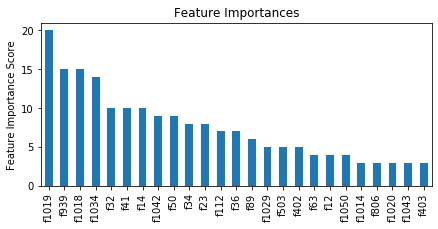

In [11]:
#Calling function and feeding data by chunk

df_size = len(train)
print("df size :", df_size)
chunk = 3
print((len(train)/ chunk))
range_chunk = int (len(train)/ chunk)
init_range_chunk = range_chunk
print("rc:", range_chunk)

for chunk_len in np.arange(chunk):
    
    if(chunk_len != chunk-1):
        temp_chunk_data = train.iloc[0: range_chunk]
        range_chunk = range_chunk + init_range_chunk
    else:
        temp_chunk=train
    print ("size:", len(temp_chunk))
    
    X_all = temp_chunk_data
    #print(X_all.head())
    y_all = X_all['Response']
    X_all = X_all.iloc[:,:-1].values
    print(y_all)
    from xgboost.sklearn import XGBClassifier
    xgb1 = XGBClassifier(learning_rate=0.05,
                     base_score=0.0056,
                     n_estimators=50,
                     min_child_weight=1,
                     gamma=0.1,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective='binary:logistic',
                     nthread=4,
                     scale_pos_weight=3)
    modelfit(xgb1, X_all, y_all, chunk_len)
